# The Method of Regularized Stokeslets Using the Fast Multiple Method #

The following code represents a modified implementation of the Method of Regularized Stokeslets (MRS). In previous work with Professor Fabien Evrard, I implemented a MRS solver in Python based on the foundational paper [The Method of Regularized Stokeslets](https://epubs.siam.org/doi/abs/10.1137/S106482750038146X?journalCode=sjoce3) by Dr. Ricardo Cortez. This solver modeled a sphere and a surrounding 3D fluid domain, each discretized using a set of equispaced points.

While the MRS is a well-established approach in applied mathematics and biological fluid dynamics, and reduces the physical problem to a single dense linear system, the computational cost of the full formulation scales as $\mathcal{O}(N^2)$. To address this issue, particular attention was given to the portion of the solver responsible for computing the induced velocity field in the 3D domain. In the original implementation, evaluating the velocity at a single point required summing contributions from all $N$ force points on the sphere, resulting in $N$ operations per evaluation point. Thus, for $N = 100$, computing the velocity at one location required 100 separate interactions.

A more efficient approach was presented in the paper [Kernel-independent fast multipole method within the framework of regularized Stokeslets](https://www.sciencedirect.com/science/article/pii/S0889974615302450?via=ihub) by Dr. Minghao Rostami and Dr. Sarah Olson. The Fast Multipole Method, originally developed for solving the N-body problem by hierarchically grouping gravitational interactions, can be adapted to MRS by grouping the influence of nearby forcing points.

Intuitively, the idea is that not all force points contribute equally to the velocity at a given location, particularly if they are far from the evaluation point. Following the framework laid out by Dr. Rostami and Dr. Olson, two key modifications were introduced into the original MRS implementation:

1. Hierarchical decomposition of the 3D domain
2. Induced velocity calculation using grouped forcing contributions

The first step involves partitioning the 3D domain using an octree structure, where the refinement level is determined by the number of force points per lowest-level box. With the help of a tree-based data structure and helper functions, this hierarchical decomposition was implemented successfully.

The second step redefines the velocity evaluation process. Instead of calculating interactions with each individual forcing point, the solver computes velocity based on grouped contributions — specifically, an average location and force summation for each node at every level of the tree. When evaluating velocity at a point in the domain, the method identifies which node the point belongs to and then sums contributions from all other nodes on the same tree level. This greatly reduces the number of computations while still preserving key flow characteristics.

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import time

In [90]:
# =============================================================================
# CubeNode Class for Hierarchical Octree Structure
# =============================================================================

class CubeNode:
    def __init__(self, level, bounds, points=None, parent=None):
        self.level = level
        self.bounds = bounds  # (xmin, ymin, zmin, xmax, ymax, zmax)
        self.points = points if points is not None else []
        self.parent = parent
        self.children = []

    def __repr__(self):
        return f"CubeNode(level={self.level}, bounds={self.bounds}, points={len(self.points)})"

    def subdivide(self, points, n=2):
        if self.children:
            return  
  
        xmin, ymin, zmin, xmax, ymax, zmax = self.bounds
        dx, dy, dz = (xmax - xmin) / n, (ymax - ymin) / n, (zmax - zmin) / n

        for i in range(n):
            for j in range(n):
                for k in range(n):
                    child_bounds = (
                        xmin + i * dx, ymin + j * dy, zmin + k * dz,
                        xmin + (i + 1) * dx, ymin + (j + 1) * dy, zmin + (k + 1) * dz
                    )
                    child_points = [
                        idx for idx in self.points
                        if (child_bounds[0] <= points[idx][0] < child_bounds[3] and
                            child_bounds[1] <= points[idx][1] < child_bounds[4] and
                            child_bounds[2] <= points[idx][2] < child_bounds[5])
                    ]
                    self.children.append(CubeNode(self.level + 1, child_bounds, child_points, self))

    def get_all_descendants(self):
        descendants = []
        for child in self.children:
            descendants.append(child)
            descendants.extend(child.get_all_descendants())
        return descendants

    def get_leaves(self):
        return [self] if not self.children else [leaf for child in self.children for leaf in child.get_leaves()]

    def get_points_coordinates_and_forces(self, pair_dict):
        pts = np.array([pair_dict[idx]['point'] for idx in self.points])
        fcs = np.array([pair_dict[idx]['force'] for idx in self.points])

        return pts, fcs


# =============================================================================
# Sphere Generation
# =============================================================================

def generate_sphere_points(N, r):
    a = 4 * np.pi / N
    d = np.sqrt(a)
    M_theta = int(round(np.pi / d))
    d_theta = np.pi / M_theta
    d_phi = a / d_theta

    epsilon = 1.5 * d * r
    points = []

    for m in range(M_theta):
        theta = (np.pi * (m + 0.5)) / M_theta
        M_phi = int(round((2 * np.pi * np.sin(theta)) / d_phi))
        for n in range(M_phi):
            phi = (2 * np.pi * n) / M_phi
            x = r * np.sin(theta) * np.cos(phi)
            y = r * np.sin(theta) * np.sin(phi)
            z = r * np.cos(theta)
            points.append([x, y, z])

    return np.array(points), epsilon


# =============================================================================
# Method of Regularized Stokeslets - Force Solver
# =============================================================================

def get_force_values(points, radius, eps_input):
    N = len(points)
    u_inf = 1.0
    v = u_inf * np.tile([-1, 0, 0], N).reshape(-1, 1)

    def S_func(x, x0, eps):
        r = np.linalg.norm(x - x0)
        epsilon = eps
        denom = (r**2 + epsilon**2)**1.5
        p1 = np.eye(3) * ((r**2 + 2 * epsilon**2) / denom)
        p2 = np.outer(x - x0, x - x0) / denom
        return p1 + p2

    M = np.zeros((3 * N, 3 * N))
    for i in range(N):
        for j in range(N):
            S = S_func(points[j], points[i], eps_input)
            M[3*i:3*i+3, 3*j:3*j+3] = S

    F = (8 * np.pi) * np.linalg.solve(M, v)
    return F.reshape(N, 3)


# =============================================================================
# Tree Construction and Force Aggregation
# =============================================================================

def create_pair(points, forces):
    return {i: {'point': points[i], 'force': forces[i]} for i in range(len(points))}


def build_tree(points, domain_bounds, max_levels=5, n=2):
    root = CubeNode(0, domain_bounds, list(range(len(points))))
    to_process = [root]

    while to_process:
        node = to_process.pop()
        if node.level < max_levels and len(node.points) > 0:
            node.subdivide(points, n)
            to_process.extend(node.children)

    return root
    

def compute_averages_and_force_sums(tree, pair_dict, max_level=1):
    results = {}

    all_nodes = [tree] + tree.get_all_descendants()  
    level_buckets = {}

    for node in all_nodes:
        if node.level not in level_buckets:
            level_buckets[node.level] = []
        level_buckets[node.level].append(node)

    for level in range(max_level, -1, -1):
        level_nodes = level_buckets.get(level, [])
        level_data = []

        for node in level_nodes:
            pts, fcs = node.get_points_coordinates_and_forces(pair_dict)
            if len(pts) > 0:
                avg = np.mean(pts, axis=0)
                fsum = np.sum(fcs, axis=0)
                level_data.append({
                    'bounds': node.bounds,
                    'average': avg,
                    'force_sum': fsum,
                    'num_points': len(pts)
                })

        results[level] = level_data

    return results

# =============================================================================
# Tree Visualization 
# =============================================================================

def visualize_entire_tree(tree, points):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', s=5, alpha=0.6, label="Sphere Points")

    all_nodes = [tree] + tree.get_all_descendants()
    max_level = max(node.level for node in all_nodes)

    for node in all_nodes:
        xmin, ymin, zmin, xmax, ymax, zmax = node.bounds
        x = [xmin, xmax, xmax, xmin, xmin, xmax, xmax, xmin]
        y = [ymin, ymin, ymax, ymax, ymin, ymin, ymax, ymax]
        z = [zmin, zmin, zmin, zmin, zmax, zmax, zmax, zmax]
        verts = [
            [0, 1, 2, 3], [4, 5, 6, 7],
            [0, 1, 5, 4], [2, 3, 7, 6],
            [1, 2, 6, 5], [0, 3, 7, 4]
        ]
        color = plt.cm.viridis(node.level / max_level)
        for v in verts:
            ax.plot([x[i] for i in v + [v[0]]],
                    [y[i] for i in v + [v[0]]],
                    [z[i] for i in v + [v[0]]],
                    color=color, linewidth=0.8, alpha=0.7)

    ax.set_title("All Octree Boxes")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1, 1, 1])
    ax.legend()
    plt.tight_layout()
    plt.show()

To check that the hierarchal decomposition and force aggregation was exectued correctly, the code was tested at a few different values of $N$. For each test case, the force aggregation was compared against the MRS result as well as at each level to ensure that the expected behavior was being performed.


=== Total Force Returned by MRS ===
Fx: -4.041981712854028
Fy: -6.17861466543314e-18
Fz: 0.0

=== Total Force Sum by Level ===
Level 1: Force Sum = [-4.04198171e+00 -6.17861467e-18  0.00000000e+00]
Level 0: Force Sum = [-4.04198171e+00 -6.17861467e-18  0.00000000e+00]
Deepest level in tree: 1


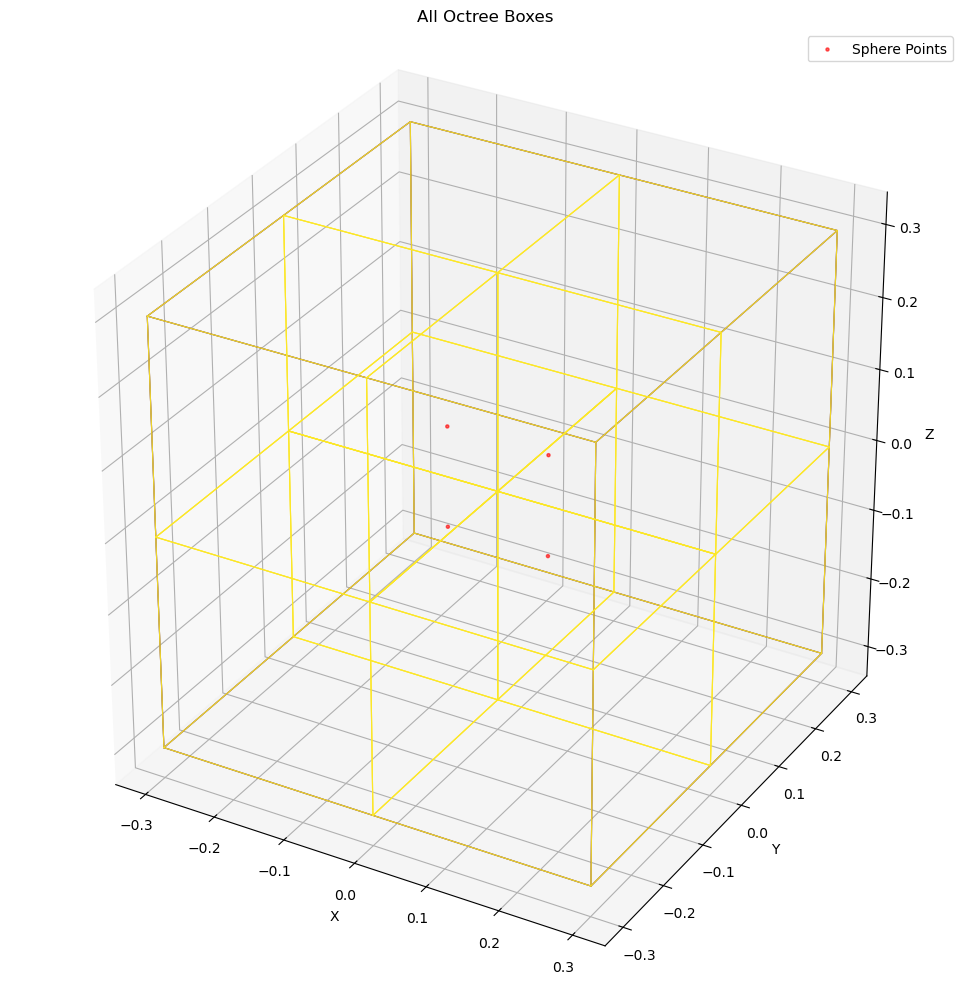

In [91]:
# =============================================================================
# Test Run: N=4
# =============================================================================

N = 4
radius = 0.1
bounds = (-0.3, -0.3, -0.3, 0.3, 0.3, 0.3)

# Generate points & solve forces
points, epsilon = generate_sphere_points(N, radius)
forces = get_force_values(points, radius, epsilon)
print("\n=== Total Force Returned by MRS ===")
print('Fx:', np.sum(forces[:,0]))
print('Fy:', np.sum(forces[:,1]))
print('Fz:', np.sum(forces[:,2]))

pair_dict = create_pair(points, forces)
tree = build_tree(points, bounds, 1)
averages = compute_averages_and_force_sums(tree, pair_dict)

def print_force_sums_by_level(averages):
    print("\n=== Total Force Sum by Level ===")
    levels_sorted = sorted(averages.keys(), reverse=True)  
    for level in levels_sorted:
        total_force = np.zeros(3)
        for node in averages[level]:
            total_force += node['force_sum']
        print(f"Level {level}: Force Sum = {total_force}")

print_force_sums_by_level(averages)

max_depth = max(node.level for node in [tree] + tree.get_all_descendants())
print(f"Deepest level in tree: {max_depth}") 

visualize_entire_tree(tree, points)


=== Total Force Returned by MRS ===
Fx: -2.9579246505691144
Fy: -1.5612511283791264e-16
Fz: -8.326672684688674e-17

=== Total Force Sum by Level ===
Level 3: Force Sum = [-2.95792465e+00 -5.98773619e-19 -5.55111512e-17]
Level 2: Force Sum = [-2.95792465e+00 -1.11022302e-16  0.00000000e+00]
Level 1: Force Sum = [-2.95792465e+00 -1.11022302e-16  0.00000000e+00]
Level 0: Force Sum = [-2.95792465e+00 -1.00613962e-16 -2.77555756e-17]
Deepest level in tree: 3


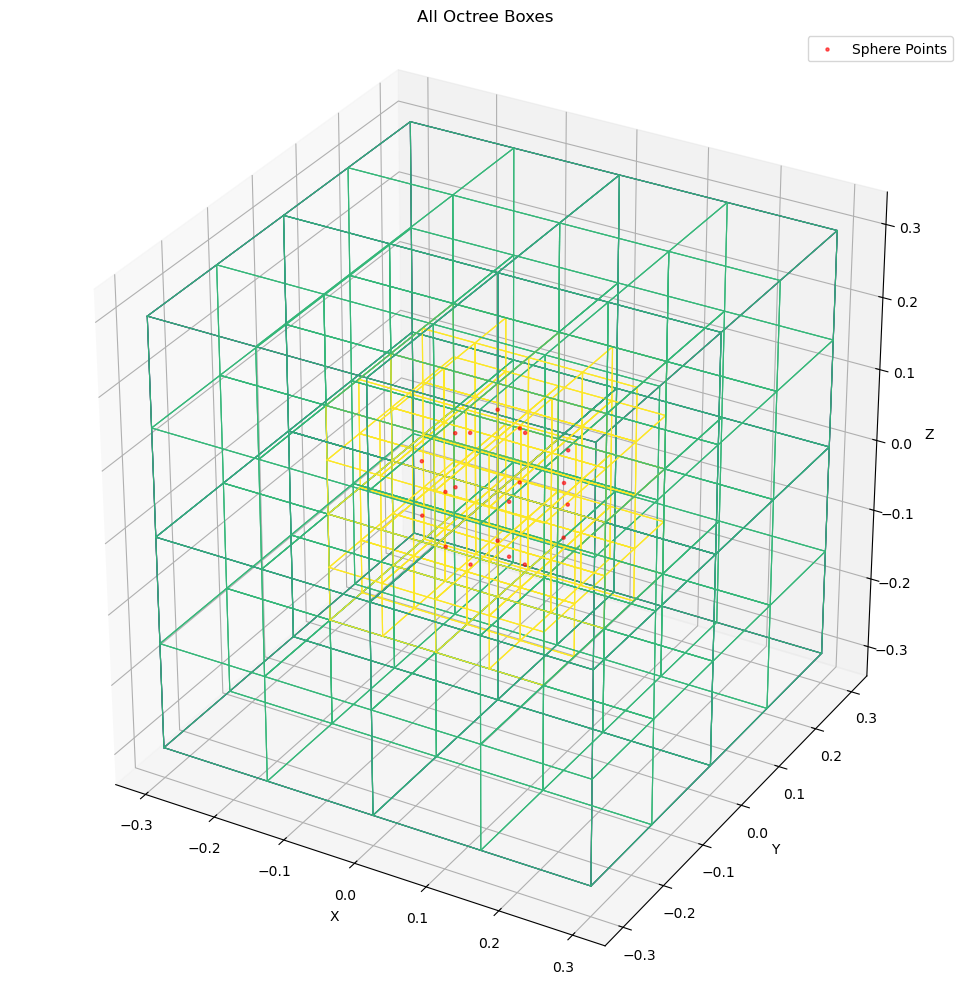

In [92]:
# =============================================================================
# CubeNode Class for Hierarchical Octree Structure
# =============================================================================

class CubeNode:
    def __init__(self, level, bounds, points=None, parent=None):
        self.level = level
        self.bounds = bounds  # (xmin, ymin, zmin, xmax, ymax, zmax)
        self.points = points if points is not None else []
        self.parent = parent
        self.children = []

    def __repr__(self):
        return f"CubeNode(level={self.level}, bounds={self.bounds}, points={len(self.points)})"

    def subdivide(self, points, n=2):
        if self.children:
            return 
  
        xmin, ymin, zmin, xmax, ymax, zmax = self.bounds
        dx, dy, dz = (xmax - xmin) / n, (ymax - ymin) / n, (zmax - zmin) / n

        for i in range(n):
            for j in range(n):
                for k in range(n):
                    child_bounds = (
                        xmin + i * dx, ymin + j * dy, zmin + k * dz,
                        xmin + (i + 1) * dx, ymin + (j + 1) * dy, zmin + (k + 1) * dz
                    )
                    child_points = [
                        idx for idx in self.points
                        if (child_bounds[0] <= points[idx][0] < child_bounds[3] and
                            child_bounds[1] <= points[idx][1] < child_bounds[4] and
                            child_bounds[2] <= points[idx][2] < child_bounds[5])
                    ]
                    self.children.append(CubeNode(self.level + 1, child_bounds, child_points, self))     
    
    def get_all_descendants(self):
        descendants = []
        for child in self.children:
            descendants.append(child)
            descendants.extend(child.get_all_descendants())
        return descendants

    def get_leaves(self):
        return [self] if not self.children else [leaf for child in self.children for leaf in child.get_leaves()]

    def get_points_coordinates_and_forces(self, pair_dict):
        pts = np.array([pair_dict[idx]['point'] for idx in self.points])
        fcs = np.array([pair_dict[idx]['force'] for idx in self.points])

        return pts, fcs


# =============================================================================
# Sphere Generation
# =============================================================================

def generate_sphere_points(N, r):
    a = 4 * np.pi / N
    d = np.sqrt(a)
    M_theta = int(round(np.pi / d))
    d_theta = np.pi / M_theta
    d_phi = a / d_theta

    epsilon = 1.5 * d * r
    points = []

    for m in range(M_theta):
        theta = (np.pi * (m + 0.5)) / M_theta
        M_phi = int(round((2 * np.pi * np.sin(theta)) / d_phi))
        for n in range(M_phi):
            phi = (2 * np.pi * n) / M_phi
            x = r * np.sin(theta) * np.cos(phi)
            y = r * np.sin(theta) * np.sin(phi)
            z = r * np.cos(theta)
            points.append([x, y, z])

    return np.array(points), epsilon


# =============================================================================
# Method of Regularized Stokeslets - Force Solver
# =============================================================================

def get_force_values(points, radius, eps_input):
    N = len(points)
    u_inf = 1.0
    v = u_inf * np.tile([-1, 0, 0], N).reshape(-1, 1)

    def S_func(x, x0, eps):
        r = np.linalg.norm(x - x0)
        epsilon = eps
        denom = (r**2 + epsilon**2)**1.5
        p1 = np.eye(3) * ((r**2 + 2 * epsilon**2) / denom)
        p2 = np.outer(x - x0, x - x0) / denom
        return p1 + p2

    M = np.zeros((3 * N, 3 * N))
    for i in range(N):
        for j in range(N):
            S = S_func(points[j], points[i], eps_input)
            M[3*i:3*i+3, 3*j:3*j+3] = S

    F = (8 * np.pi) * np.linalg.solve(M, v)
    return F.reshape(N, 3)


# =============================================================================
# Tree Construction and Force Aggregation
# =============================================================================

def create_pair(points, forces):
    return {i: {'point': points[i], 'force': forces[i]} for i in range(len(points))}


def build_tree(points, domain_bounds, max_levels=5, n=2):
    root = CubeNode(0, domain_bounds, list(range(len(points))))
    to_process = [root]

    while to_process:
        node = to_process.pop()
        if node.level < max_levels and len(node.points) > 0:
            node.subdivide(points, n)
            to_process.extend(node.children)

    return root
    

def compute_averages_and_force_sums(tree, pair_dict, max_level=3):
    results = {}

    all_nodes = [tree] + tree.get_all_descendants()  
    level_buckets = {}

    for node in all_nodes:
        if node.level not in level_buckets:
            level_buckets[node.level] = []
        level_buckets[node.level].append(node)

    for level in range(max_level, -1, -1):
        level_nodes = level_buckets.get(level, [])
        level_data = []

        for node in level_nodes:
            pts, fcs = node.get_points_coordinates_and_forces(pair_dict)
            if len(pts) > 0:
                avg = np.mean(pts, axis=0)
                fsum = np.sum(fcs, axis=0)
                level_data.append({
                    'bounds': node.bounds,
                    'average': avg,
                    'force_sum': fsum,
                    'num_points': len(pts)
                })

        results[level] = level_data

    return results

# =============================================================================
# Tree Visualization 
# =============================================================================

def visualize_entire_tree(tree, points):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', s=5, alpha=0.6, label="Sphere Points")

    all_nodes = [tree] + tree.get_all_descendants()
    max_level = max(node.level for node in all_nodes)

    for node in all_nodes:
        xmin, ymin, zmin, xmax, ymax, zmax = node.bounds
        x = [xmin, xmax, xmax, xmin, xmin, xmax, xmax, xmin]
        y = [ymin, ymin, ymax, ymax, ymin, ymin, ymax, ymax]
        z = [zmin, zmin, zmin, zmin, zmax, zmax, zmax, zmax]
        verts = [
            [0, 1, 2, 3], [4, 5, 6, 7],
            [0, 1, 5, 4], [2, 3, 7, 6],
            [1, 2, 6, 5], [0, 3, 7, 4]
        ]
        color = plt.cm.viridis(node.level / max_level)
        for v in verts:
            ax.plot([x[i] for i in v + [v[0]]],
                    [y[i] for i in v + [v[0]]],
                    [z[i] for i in v + [v[0]]],
                    color=color, linewidth=0.8, alpha=0.7)

    ax.set_title("All Octree Boxes")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1, 1, 1])
    ax.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# Test Run: N = 20
# =============================================================================

N = 20
radius = 0.1
bounds = (-0.3, -0.3, -0.3, 0.3, 0.3, 0.3)

points, epsilon = generate_sphere_points(N, radius)
forces = get_force_values(points, radius, epsilon)
print("\n=== Total Force Returned by MRS ===")
print('Fx:', np.sum(forces[:,0]))
print('Fy:', np.sum(forces[:,1]))
print('Fz:', np.sum(forces[:,2]))

pair_dict = create_pair(points, forces)
tree = build_tree(points, bounds, 3)
averages = compute_averages_and_force_sums(tree, pair_dict)

def print_force_sums_by_level(averages):
    print("\n=== Total Force Sum by Level ===")
    levels_sorted = sorted(averages.keys(), reverse=True)  
    for level in levels_sorted:
        total_force = np.zeros(3)
        for node in averages[level]:
            total_force += node['force_sum']
        print(f"Level {level}: Force Sum = {total_force}")

print_force_sums_by_level(averages)

max_depth = max(node.level for node in [tree] + tree.get_all_descendants())
print(f"Deepest level in tree: {max_depth}") 

visualize_entire_tree(tree, points)


=== Total Force Returned by MRS ===
Fx: -2.27341412522958
Fy: 8.630249292984615e-17
Fz: -2.168404344971009e-18

=== Total Force Sum by Level ===
Level 5: Force Sum = [-2.27341413e+00 -3.79100599e-18  4.16333634e-17]
Level 4: Force Sum = [-2.27341413e+00  3.89240071e-17  2.42861287e-17]
Level 3: Force Sum = [-2.27341413e+00 -3.46944695e-18 -4.16333634e-17]
Level 2: Force Sum = [-2.27341413e+00  5.55111512e-17  2.77555756e-17]
Level 1: Force Sum = [-2.27341413e+00  5.55111512e-17  2.77555756e-17]
Level 0: Force Sum = [-2.27341413e+00  3.25260652e-17 -7.37257477e-18]
Deepest level in tree: 5


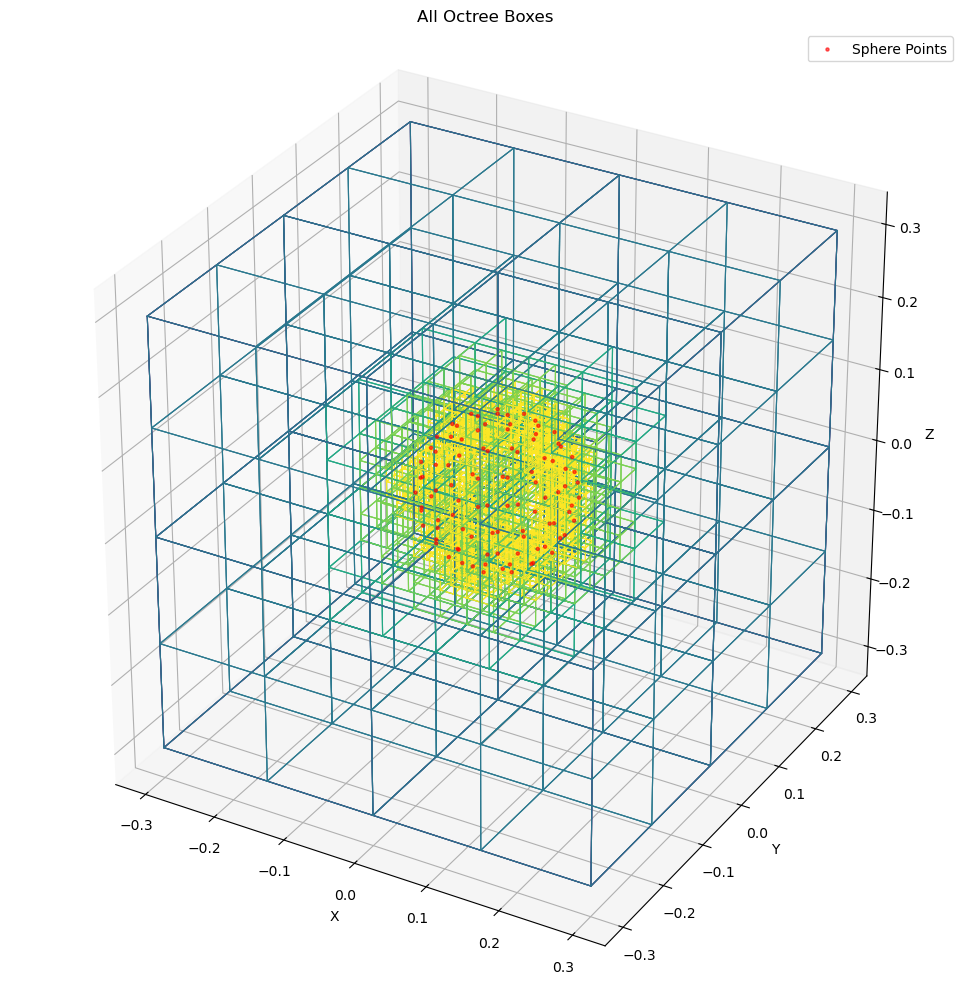

In [93]:
# =============================================================================
# CubeNode Class for Hierarchical Octree Structure
# =============================================================================

class CubeNode:
    def __init__(self, level, bounds, points=None, parent=None):
        self.level = level
        self.bounds = bounds  # (xmin, ymin, zmin, xmax, ymax, zmax)
        self.points = points if points is not None else []
        self.parent = parent
        self.children = []

    def __repr__(self):
        return f"CubeNode(level={self.level}, bounds={self.bounds}, points={len(self.points)})"

    def subdivide(self, points, n=2):
        if self.children:
            return  
  
        xmin, ymin, zmin, xmax, ymax, zmax = self.bounds
        dx, dy, dz = (xmax - xmin) / n, (ymax - ymin) / n, (zmax - zmin) / n

        for i in range(n):
            for j in range(n):
                for k in range(n):
                    child_bounds = (
                        xmin + i * dx, ymin + j * dy, zmin + k * dz,
                        xmin + (i + 1) * dx, ymin + (j + 1) * dy, zmin + (k + 1) * dz
                    )
                    child_points = [
                        idx for idx in self.points
                        if (child_bounds[0] <= points[idx][0] < child_bounds[3] and
                            child_bounds[1] <= points[idx][1] < child_bounds[4] and
                            child_bounds[2] <= points[idx][2] < child_bounds[5])
                    ]
                    self.children.append(CubeNode(self.level + 1, child_bounds, child_points, self))        
    
    def get_all_descendants(self):
        descendants = []
        for child in self.children:
            descendants.append(child)
            descendants.extend(child.get_all_descendants())
        return descendants

    def get_leaves(self):
        return [self] if not self.children else [leaf for child in self.children for leaf in child.get_leaves()]

    def get_points_coordinates_and_forces(self, pair_dict):
        pts = np.array([pair_dict[idx]['point'] for idx in self.points])
        fcs = np.array([pair_dict[idx]['force'] for idx in self.points])

        return pts, fcs


# =============================================================================
# Sphere Generation
# =============================================================================

def generate_sphere_points(N, r):
    a = 4 * np.pi / N
    d = np.sqrt(a)
    M_theta = int(round(np.pi / d))
    d_theta = np.pi / M_theta
    d_phi = a / d_theta

    epsilon = 1.5 * d * r
    points = []

    for m in range(M_theta):
        theta = (np.pi * (m + 0.5)) / M_theta
        M_phi = int(round((2 * np.pi * np.sin(theta)) / d_phi))
        for n in range(M_phi):
            phi = (2 * np.pi * n) / M_phi
            x = r * np.sin(theta) * np.cos(phi)
            y = r * np.sin(theta) * np.sin(phi)
            z = r * np.cos(theta)
            points.append([x, y, z])

    return np.array(points), epsilon


# =============================================================================
# Method of Regularized Stokeslets - Force Solver
# =============================================================================

def get_force_values(points, radius, eps_input):
    N = len(points)
    u_inf = 1.0
    v = u_inf * np.tile([-1, 0, 0], N).reshape(-1, 1)

    def S_func(x, x0, eps):
        r = np.linalg.norm(x - x0)
        epsilon = eps
        denom = (r**2 + epsilon**2)**1.5
        p1 = np.eye(3) * ((r**2 + 2 * epsilon**2) / denom)
        p2 = np.outer(x - x0, x - x0) / denom
        return p1 + p2

    M = np.zeros((3 * N, 3 * N))
    for i in range(N):
        for j in range(N):
            S = S_func(points[j], points[i], eps_input)
            M[3*i:3*i+3, 3*j:3*j+3] = S

    F = (8 * np.pi) * np.linalg.solve(M, v)
    return F.reshape(N, 3)


# =============================================================================
# Tree Construction and Force Aggregation
# =============================================================================

def create_pair(points, forces):
    return {i: {'point': points[i], 'force': forces[i]} for i in range(len(points))}


def build_tree(points, domain_bounds, max_levels=5, n=2):
    root = CubeNode(0, domain_bounds, list(range(len(points))))
    to_process = [root]

    while to_process:
        node = to_process.pop()
        if node.level < max_levels and len(node.points) > 0:
            node.subdivide(points, n)
            to_process.extend(node.children)

    return root
    

def compute_averages_and_force_sums(tree, pair_dict, max_level=5):
    results = {}

    all_nodes = [tree] + tree.get_all_descendants()  
    level_buckets = {}

    for node in all_nodes:
        if node.level not in level_buckets:
            level_buckets[node.level] = []
        level_buckets[node.level].append(node)

    for level in range(max_level, -1, -1):
        level_nodes = level_buckets.get(level, [])
        level_data = []

        for node in level_nodes:
            pts, fcs = node.get_points_coordinates_and_forces(pair_dict)
            if len(pts) > 0:
                avg = np.mean(pts, axis=0)
                fsum = np.sum(fcs, axis=0)
                level_data.append({
                    'bounds': node.bounds,
                    'average': avg,
                    'force_sum': fsum,
                    'num_points': len(pts)
                })

        results[level] = level_data

    return results

# =============================================================================
# Tree Visualization 
# =============================================================================

def visualize_entire_tree(tree, points):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', s=5, alpha=0.6, label="Sphere Points")

    all_nodes = [tree] + tree.get_all_descendants()
    max_level = max(node.level for node in all_nodes)

    for node in all_nodes:
        xmin, ymin, zmin, xmax, ymax, zmax = node.bounds
        x = [xmin, xmax, xmax, xmin, xmin, xmax, xmax, xmin]
        y = [ymin, ymin, ymax, ymax, ymin, ymin, ymax, ymax]
        z = [zmin, zmin, zmin, zmin, zmax, zmax, zmax, zmax]
        verts = [
            [0, 1, 2, 3], [4, 5, 6, 7],
            [0, 1, 5, 4], [2, 3, 7, 6],
            [1, 2, 6, 5], [0, 3, 7, 4]
        ]
        color = plt.cm.viridis(node.level / max_level)
        for v in verts:
            ax.plot([x[i] for i in v + [v[0]]],
                    [y[i] for i in v + [v[0]]],
                    [z[i] for i in v + [v[0]]],
                    color=color, linewidth=0.8, alpha=0.7)

    ax.set_title("All Octree Boxes")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1, 1, 1])
    ax.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# Test Run: N=100
# =============================================================================

N = 100
radius = 0.1
bounds = (-0.3, -0.3, -0.3, 0.3, 0.3, 0.3)

points, epsilon = generate_sphere_points(N, radius)
forces = get_force_values(points, radius, epsilon)
print("\n=== Total Force Returned by MRS ===")
print('Fx:', np.sum(forces[:,0]))
print('Fy:', np.sum(forces[:,1]))
print('Fz:', np.sum(forces[:,2]))

pair_dict = create_pair(points, forces)
tree = build_tree(points, bounds, 5)
averages = compute_averages_and_force_sums(tree, pair_dict)

def print_force_sums_by_level(averages):
    print("\n=== Total Force Sum by Level ===")
    levels_sorted = sorted(averages.keys(), reverse=True)  
    for level in levels_sorted:
        total_force = np.zeros(3)
        for node in averages[level]:
            total_force += node['force_sum']
        print(f"Level {level}: Force Sum = {total_force}")

print_force_sums_by_level(averages)

max_depth = max(node.level for node in [tree] + tree.get_all_descendants())
print(f"Deepest level in tree: {max_depth}") 

visualize_entire_tree(tree, points)

Now, since it can be shown that the domain decomposition and force reconstruction has been executed accurately, the next step of the improved velocity distribution calculation can be implemented.

In [94]:
# =============================================================================
# VELOCITY POINT GENERATION
# =============================================================================

def generate_velocity_points(domain_bounds, num_points_target):

    N_side = int(np.ceil(num_points_target ** (1/3)))
    x_vals = np.linspace(domain_bounds[0], domain_bounds[3], N_side)
    y_vals = np.linspace(domain_bounds[1], domain_bounds[4], N_side)
    z_vals = np.linspace(domain_bounds[2], domain_bounds[5], N_side)

    velocity_points = np.array([[x, y, z] for x in x_vals for y in y_vals for z in z_vals])
    return velocity_points


# =============================================================================
# REGULARIZED STOKESLET KERNEL
# =============================================================================

def S_func(x, x0, eps, d, r):
    radius = np.linalg.norm(x - x0)
    epsilon = eps * d * r
    denom = (radius**2 + epsilon**2)**1.5
    p1 = np.eye(3) * ((radius**2 + 2 * epsilon**2) / denom)
    p2 = np.outer(x - x0, x - x0) / denom
    return p1 + p2


# =============================================================================
# TREE NAVIGATION
# =============================================================================

def find_node_containing_point(tree_root, point):

    def in_bounds(pt, bounds):
        x, y, z = pt
        xmin, ymin, zmin, xmax, ymax, zmax = bounds
        return (xmin <= x <= xmax) and (ymin <= y <= ymax) and (zmin <= z <= zmax)

    current = tree_root
    if not in_bounds(point, current.bounds):
        return None
    
    while current.children:
        for child in current.children:
            if in_bounds(point, child.bounds):
                current = child
                break
        else:
            break

    return current


# =============================================================================
# VELOCITY CALCULATION
# =============================================================================

def calculate_velocities(velocity_points, tree, averages, eps, d, r):

    velocities = []

    for vp in velocity_points:
        node = find_node_containing_point(tree, vp)
        level = node.level 
        level_nodes = averages.get(level, [])
        v_total = np.array([1.0, 0.0, 0.0]) 

        for other_node in level_nodes:         
            S = S_func(vp, other_node['average'], eps, d, r)
            v_total += S/(8*np.pi) @ other_node['force_sum']
        velocities.append(v_total)

    return np.array(velocities)

# =============================================================================
# VISUALIZATION - 2D CROSS SECTION
# =============================================================================

def visualize_velocity_cross_section_with_points(velocity_points, velocities, sphere_center, sphere_radius,
                                                 plane='xy', slice_pos=0.0, tolerance=0.01):
    plane_axes = {'xy': (0, 1, 2), 'xz': (0, 2, 1), 'yz': (1, 2, 0)}
    if plane not in plane_axes:
        raise ValueError("Plane must be 'xy', 'xz', or 'yz'")

    i, j, k = plane_axes[plane]
    mask = np.abs(velocity_points[:, k] - slice_pos) < tolerance
    vp_slice = velocity_points[mask]
    v_slice = velocities[mask]

    in_plane = vp_slice[:, [i, j]]
    center_2d = sphere_center[[i, j]]
    dists = np.linalg.norm(in_plane - center_2d, axis=1)

    outside_mask = dists > sphere_radius
    x = vp_slice[outside_mask, i]
    y = vp_slice[outside_mask, j]
    u = v_slice[outside_mask, i]
    v = v_slice[outside_mask, j]

    xlabel, ylabel = ['X', 'Y', 'Z'][i], ['X', 'Y', 'Z'][j]

    plt.figure(figsize=(8, 6))
    plt.quiver(x, y, u, v, color='blue')  
    plt.scatter(x, y, color='red', s=10, label="Velocity Points")

    circle = plt.Circle(center_2d, sphere_radius, color='red', alpha=0.3, linewidth=2)
    plt.gca().add_artist(circle)

    plt.title(f'True Velocity Field in {plane.upper()} Plane at {slice_pos}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

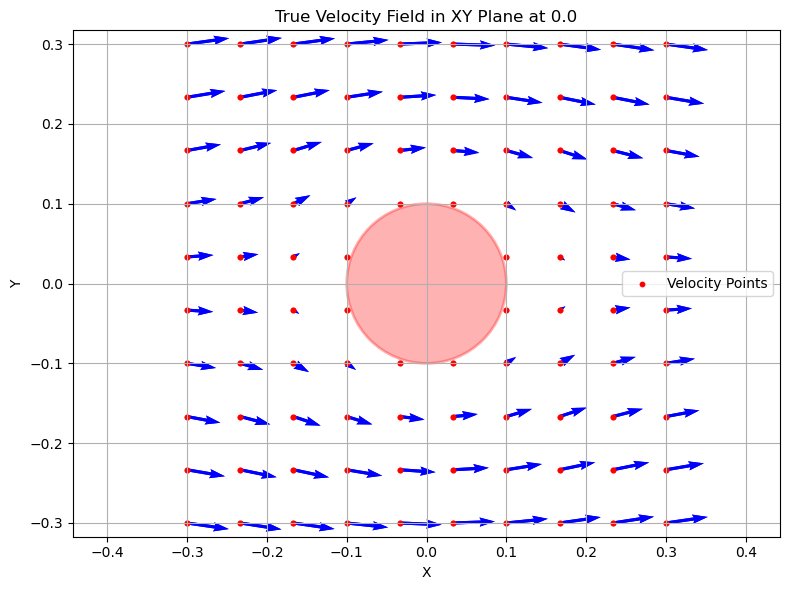

In [95]:
num_velocity_points = 1000
sphere_center = np.array([0, 0, 0])
sphere_radius = 0.1

vel_points = generate_velocity_points(bounds, num_velocity_points)
d = np.sqrt(4 * np.pi / N)  # spacing estimate from surface discretization
velocities = calculate_velocities(vel_points, tree, averages, eps=1.5, d=d, r=sphere_radius)

visualize_velocity_cross_section_with_points(vel_points, velocities, sphere_center, sphere_radius, plane='xy', slice_pos=0.0, tolerance=0.05)

Upon visual inspection, the velocity field generated by the updated FMM method seems to closely match the true MRS function. However, the main purpose of this task was to see whether this is truly a less computationally expensive solver. To confirm this, the time taken to calculate the induced velocity can be recorded for this updated solver as well as the original MRS solver.

In [96]:
# Time taken to calculate induced velocity by the updated FMM method
start = time.perf_counter()
velocities = calculate_velocities(vel_points, tree, averages, eps=1.5, d=d, r=sphere_radius)
end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

Elapsed time: 0.093036 seconds


In [97]:
# Time taken to calculate induced velcoity by the original MRS solver

def MRS(num_points, eps): 

    # Import Statements 
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    '''Part 1: Setting Points on the Sphere'''

    # Following Algorith for Equispaced Points on a Sphere
    N = num_points  # Number of points on our sphere
    a = 4.0 * np.pi / N  
    d = np.sqrt(a)
    M_theta = int(round(np.pi / d))
    d_theta = np.pi / M_theta
    d_phi = a / d_theta

    sphere_points_list = []
    r = 0.01  # Radius of sphere (meters)

    for m in range(M_theta):
        theta = (np.pi * (m + 0.5)) / M_theta
        M_phi = int(round(((2 * np.pi) * np.sin(theta)) / d_phi))
        for n in range(M_phi):
            phi = (2 * np.pi * n) / M_phi
            x = r * np.sin(theta) * np.cos(phi)
            y = r * np.sin(theta) * np.sin(phi)
            z = r * np.cos(theta)
            vector = np.array([x, y, z])
            sphere_points_list.append(vector)

    sphere_points = np.array(sphere_points_list)
    N = len(sphere_points) # Reset N to match number of points generated by algorithm 

    '''
    Part 2: Solving for Drag Force 
    '''

    # Building Free Stream Velocity Vector
    u_inf = 1 # Setting magnitude of free stream velocity (m/s)
    vec = np.tile([-1, 0, 0], N)
    vel = u_inf * vec 
    v = vel.reshape(-1, 1)

    # Building S Function (combination of B and G matrices)
    def S_func(x, x0, eps2, d, r):
        radius = np.linalg.norm(x-x0)
        epsilon = eps2 * d * r
        p1 = np.eye(3,3) * ((radius**2 + 2*epsilon**2)/(radius**2+epsilon**2)**(3/2))
        p2 = (1/(radius**2+epsilon**2)**(3/2)) * np.outer(x-x0, x-x0)
        S = p1 + p2
        return S

    # Building M Matrix 
    M = np.zeros((3*N,3*N))
    for i in range(N):
        for j in range(N):
            for k in range(3):
                for l in range(3):
                    S = S_func(sphere_points[j], sphere_points[i], eps, d, r)
                    M[3*i+k][3*j+l] = S[k][l]

    # Solving for Force Vector
    F = np.linalg.solve(M, v)
    F_matrix = F.reshape(N, 3)
    Fx = np.sum(F_matrix[:, 0])
    Fy = np.sum(F_matrix[:, 1])
    Fz = np.sum(F_matrix[:, 2])
    F_vector = (8*np.pi) * np.array([Fx, Fy, Fz]) # Including 8pi correcting factor 

    return sphere_points, N, r, u_inf, F, F_vector


# Calling MRS Function:
sphere_points2, N2, r2, u_inf2, F_unstacked2, F2 = MRS(100, 1.5)

start = time.perf_counter()

# Regular Grid Generation 
L = 1 # Length (meters)
W = 1 # Width (meters)
H = 1 # Height (meters)
Nx = 10
Ny = 10
Nz = 11
Ngrid = Nx*Ny*Nz

x0 = -3*r2; x1 = 3*r2
y0 = -3*r2; y1 = 3*r2
z0 = -3*r2; z1 = 3*r2
dx = (x1-x0) / (Nx - 1)
dy = (y1-y0) / (Ny - 1)
dz = (z1-z0) / (Nz - 1)

# Building S Function (combination of B and G matrices)
def S_func(x, x0, eps, d, r):
    radius = np.linalg.norm(x-x0)
    epsilon = eps * d * r
    p1 = np.eye(3,3) * ((radius**2 + 2*epsilon**2)/(radius**2+epsilon**2)**(3/2))
    p2 = (1/(radius**2+epsilon**2)**(3/2)) * np.outer(x-x0, x-x0)
    S = p1 + p2
    return S

fv_points = []
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            x_coord = x0 + x * dx
            y_coord = y0 + y * dy
            z_coord = z0 + z * dz
            fv_points.append([x_coord, y_coord, z_coord])
FV_points = np.array(fv_points)

# Reparametrize M Matrix
M_list1 = [] 
M1 = np.zeros((3*Ngrid,3*N2)) 
for i in range(Ngrid):
    for j in range(N2):
        for k in range(3):
            for l in range(3):
                S = S_func(sphere_points2[j], FV_points[i], 1.5, np.sqrt(4.0 * np.pi / N2), r2)
                M1[3*i+k][3*j+l] = S[k][l]

# Solving for Velocity Around Sphere
FV_vel = M1 @ F_unstacked2
FV_vel_matrix = np.reshape(FV_vel, (-1, 3))


# Solving for Velocity Around Sphere
FV_vel = M1 @ F_unstacked2
FV_vel_matrix = np.reshape(FV_vel, (-1, 3))

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")


Elapsed time: 6.336090 seconds


As can be seen, the new MRS implementation with the Fast Multipole Method is several orders of magnitude quicker when solving for the induced velocity of flow around a sphere.